In [23]:
%pip install pandas
import random, csv
from pathlib import Path
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt

SEED = 1337
random.seed(SEED)

def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'lakefile.lean').exists() and (p / 'Makefile').exists():
            return p
    return start

try:
    start_path = Path(__file__).resolve().parent
except NameError:
    start_path = Path.cwd().resolve()

ROOT = find_repo_root(start_path)
RESULTS_DIR = ROOT / "results" / date.today().isoformat() / "stress_firebreak"
FIG_DIR = ROOT / "fig"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

rows = []
for _ in range(96):
    k = random.choice([2,3,4])
    n = random.choice([2**p for p in range(6, 14)])
    d = random.choice([1,2,3])
    extra = random.choice([1,2,4])
    pass_region = (d <= 3) and (extra == 1)
    rows.append({"k": k, "n": n, "d": d, "extra": extra, "pass": int(pass_region)})

df = pd.DataFrame(rows)
out_csv = RESULTS_DIR / "stress_matrix.csv"
df.to_csv(out_csv, index=False)
print(f"wrote {out_csv}")


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
wrote C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\results\2025-08-28\stress_firebreak\stress_matrix.csv


In [24]:
# Full-factorial experiment with deterministic and probabilistic criteria
import os, subprocess, hashlib
from math import log2, sqrt, exp
import yaml
import pandas as pd
import numpy as np

# Config
GRID_K = [2, 3, 4]
GRID_D = [1, 2, 3]
GRID_EXTRA = [1, 2, 4]
GRID_N = [2**p for p in range(6, 14)]
T = 200
SEED = 1337
# Budget model params
c = 1.0
a = 1.0
gamma = 0.5  # inflation per extra-1
alpha = 1.5  # logistic steepness

# Deterministic per-cell RNG using stable hash (independent of Python hash seed)
def stable_rng(seed_base: int, *keys: int):
    s = ":".join(map(str, keys)).encode("utf-8")
    h = int(hashlib.sha256(s).hexdigest(), 16) % (2**31 - 1)
    return np.random.default_rng(seed_base + h)

# Resolve root/dirs from earlier cell
ROOT = ROOT
RESULTS_DIR = RESULTS_DIR
FIG_DIR = FIG_DIR

# Save config.yaml
try:
    git_commit = subprocess.check_output(["git", "rev-parse", "--short", "HEAD"], stderr=subprocess.DEVNULL).decode().strip()
except Exception:
    git_commit = "unknown"
config = {
    "k": GRID_K,
    "d": GRID_D,
    "extra": GRID_EXTRA,
    "n": GRID_N,
    "T": T,
    "seed": SEED,
    "params": {"c": c, "a": a, "gamma": gamma, "alpha": alpha},
    "git": {"commit": git_commit},
}
with open(RESULTS_DIR / "config.yaml", "w", encoding="utf-8") as f:
    yaml.safe_dump(config, f, sort_keys=False, allow_unicode=True)

# Generate raw data
raw_rows = []
for k in GRID_K:
    for d in GRID_D:
        for extra in GRID_EXTRA:
            for n in GRID_N:
                rng = stable_rng(SEED, k, d, extra, n)
                B = c * d * log2(n)
                R = a * k * log2(n)
                R_eff = R * (1.0 + gamma * (extra - 1))
                prob = 1.0 / (1.0 + exp(-alpha * (B - R_eff)))
                for t in range(T):
                    det = 1 if B >= R_eff else 0
                    prb = 1 if rng.random() < prob else 0
                    raw_rows.append({
                        "k": k, "d": d, "extra": extra, "n": n, "trial": t,
                        "pass_det": det, "pass_prob": prb,
                    })

df_raw = pd.DataFrame(raw_rows)
raw_csv = RESULTS_DIR / "stress_matrix_raw.csv"
df_raw.to_csv(raw_csv, index=False)
print(f"wrote {raw_csv}")

# Wilson CI for binomial proportion
from math import erf

def wilson_ci(k_succ: int, n_tot: int, z: float = 1.96):
    if n_tot == 0:
        return (0.0, 0.0, 0.0)
    p_hat = k_succ / n_tot
    denom = 1 + z*z/n_tot
    center = (p_hat + z*z/(2*n_tot)) / denom
    half = (z * sqrt((p_hat*(1-p_hat) + z*z/(4*n_tot)) / n_tot)) / denom
    return (p_hat, max(0.0, center - half), min(1.0, center + half))

# Aggregate per cell (k,d,extra,n)
agg_rows = []
for (k_, d_, extra_, n_), g in df_raw.groupby(["k", "d", "extra", "n"], sort=False):
    N = len(g)
    s_det = int(g["pass_det"].sum())
    s_prob = int(g["pass_prob"].sum())
    p_det = s_det / N
    p_prob, ci_lo, ci_hi = wilson_ci(s_prob, N)
    agg_rows.append({
        "k": k_, "d": d_, "extra": extra_, "n": n_, "N": N,
        "pass_rate_det": p_det,
        "pass_rate_prob": p_prob,
        "ci_low_prob": ci_lo, "ci_high_prob": ci_hi,
    })

agg = pd.DataFrame(agg_rows)
agg_csv = RESULTS_DIR / "stress_matrix_agg.csv"
agg.to_csv(agg_csv, index=False)
print(f"wrote {agg_csv}")



wrote C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\results\2025-08-28\stress_firebreak\stress_matrix_raw.csv
wrote C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\results\2025-08-28\stress_firebreak\stress_matrix_agg.csv


In [25]:
# Visualization: bar with error bars and heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot: pass_rate_prob by k (hue=extra) faceted by d
for d_ in GRID_D:
    sub = agg[agg["d"] == d_]
    # Average over n for compactness
    bar = sub.groupby(["k", "extra"], as_index=False).agg(
        mean_rate=("pass_rate_prob", "mean"),
        ci_low=("ci_low_prob", "mean"),
        ci_high=("ci_high_prob", "mean"),
        N=("N", "sum"),
    )
    plt.figure(figsize=(7,4))
    ax = sns.barplot(data=bar, x="k", y="mean_rate", hue="extra", ci=None)
    # Error bars
    for i, row in bar.iterrows():
        ax.errorbar(
            x=i % len(GRID_K),
            y=row["mean_rate"],
            yerr=[[row["mean_rate"] - row["ci_low"]], [row["ci_high"] - row["mean_rate"]]],
            fmt='none', c='black', capsize=3
        )
    ax.set_title(f"Pass rate (prob., 95% CI), d={d_}, seed={SEED}")
    ax.set_ylabel("pass rate")
    plt.tight_layout()
    out_path = FIG_DIR / f"stress_matrix_bar_d{d_}.png"
    plt.savefig(out_path, dpi=160)
    print(f"saved {out_path}")
    plt.close()

# Heatmap over n×extra for each (k,d)
for k_ in GRID_K:
    for d_ in GRID_D:
        sub = agg[(agg["k"] == k_) & (agg["d"] == d_)]
        piv = sub.pivot_table(values="pass_rate_prob", index="n", columns="extra", aggfunc="mean")
        plt.figure(figsize=(6,5))
        sns.heatmap(piv, vmin=0.0, vmax=1.0, cmap="viridis", annot=False)
        plt.title(f"Heatmap pass rate (prob.), k={k_}, d={d_}")
        plt.ylabel("n")
        plt.xlabel("extra")
        out_path = FIG_DIR / f"stress_matrix_heatmap_k{k_}_d{d_}.png"
        plt.tight_layout()
        plt.savefig(out_path, dpi=160)
        print(f"saved {out_path}")
        plt.close()



saved C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\fig\stress_matrix_bar_d1.png


C:\Users\ASUS\AppData\Local\Temp\ipykernel_38652\2014654973.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=bar, x="k", y="mean_rate", hue="extra", ci=None)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_38652\2014654973.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=bar, x="k", y="mean_rate", hue="extra", ci=None)


saved C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\fig\stress_matrix_bar_d2.png
saved C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\fig\stress_matrix_bar_d3.png
saved C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\fig\stress_matrix_heatmap_k2_d1.png


C:\Users\ASUS\AppData\Local\Temp\ipykernel_38652\2014654973.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=bar, x="k", y="mean_rate", hue="extra", ci=None)


saved C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\fig\stress_matrix_heatmap_k2_d2.png
saved C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\fig\stress_matrix_heatmap_k2_d3.png
saved C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\fig\stress_matrix_heatmap_k3_d1.png
saved C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\fig\stress_matrix_heatmap_k3_d2.png
saved C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\fig\stress_matrix_heatmap_k3_d3.png
saved C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\fig\stress_matrix_heatmap_k4_d1.png
saved C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\fig\stress_matrix_heatmap_k4_d2.png
saved C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\fig\stress_matrix_heatmap_k4_d3.png


In [26]:
# Self-check: monotonicity and report
import json
from math import log2

# Backfill collision_mean if not present (derive from model B/R)
if "collision_mean" not in agg.columns:
    def _cell_coll(row):
        B = c * row["d"] * log2(row["n"])
        R = a * row["k"] * log2(row["n"]) * (1.0 + gamma * (row["extra"] - 1))
        return float(max(0.0, (R - B) / max(1.0, R)))
    agg = agg.copy()
    agg["collision_mean"] = agg.apply(_cell_coll, axis=1)

report = {"checks": []}

# Check 1: pass_rate_prob monotone non-increasing with extra for each (k,d)
fail1 = []
for (k_, d_), g in agg.groupby(["k","d"]):
    means = g.groupby("extra")["pass_rate_prob"].mean().to_dict()
    ok = (means.get(1,0)>=means.get(2,0)>=means.get(4,0))
    report["checks"].append({"type": "pass_rate_monotone_extra", "k": int(k_), "d": int(d_), "means": means, "ok": bool(ok)})
    if not ok:
        fail1.append((k_, d_))

# Check 2: collision_mean monotone non-decreasing with extra for each (k,d)
fail2 = []
for (k_, d_), g in agg.groupby(["k","d"]):
    means = g.groupby("extra")["collision_mean"].mean().to_dict()
    ok = (means.get(1,0)<=means.get(2,0)<=means.get(4,0))
    report["checks"].append({"type": "collision_monotone_extra", "k": int(k_), "d": int(d_), "means": means, "ok": bool(ok)})
    if not ok:
        fail2.append((k_, d_))

# Check 3: collision_mean decreases with d for each (k,extra)
fail3 = []
for (k_, extra_), g in agg.groupby(["k","extra"]):
    means = g.groupby("d")["collision_mean"].mean().to_dict()
    ok = (means.get(1,0)>=means.get(2,0)>=means.get(3,0))
    report["checks"].append({"type": "collision_monotone_d", "k": int(k_), "extra": int(extra_), "means": means, "ok": bool(ok)})
    if not ok:
        fail3.append((k_, extra_))

summary = {
    "pass_mono_fail": len(fail1),
    "collision_extra_mono_fail": len(fail2),
    "collision_d_mono_fail": len(fail3),
}
report["summary"] = summary

# Write JSON and Markdown
report_json = RESULTS_DIR / "stress_matrix_report.json"
report_md = RESULTS_DIR / "stress_matrix_report.md"
report_json.write_text(json.dumps(report, ensure_ascii=False, indent=2), encoding="utf-8")

lines = [
    "# Stress Matrix Self-Check\n",
    f"- pass monotonicity fails: {summary['pass_mono_fail']}\n",
    f"- collision vs extra fails: {summary['collision_extra_mono_fail']}\n",
    f"- collision vs d fails: {summary['collision_d_mono_fail']}\n",
]
report_md.write_text("".join(lines), encoding="utf-8")
print(f"wrote {report_json}")
print(f"wrote {report_md}")



wrote C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\results\2025-08-28\stress_firebreak\stress_matrix_report.json
wrote C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\results\2025-08-28\stress_firebreak\stress_matrix_report.md


saved C:\Users\ASUS\OneDrive\Documents\GitHub\Psi-TM\fig\stress_firebreak_overview.png


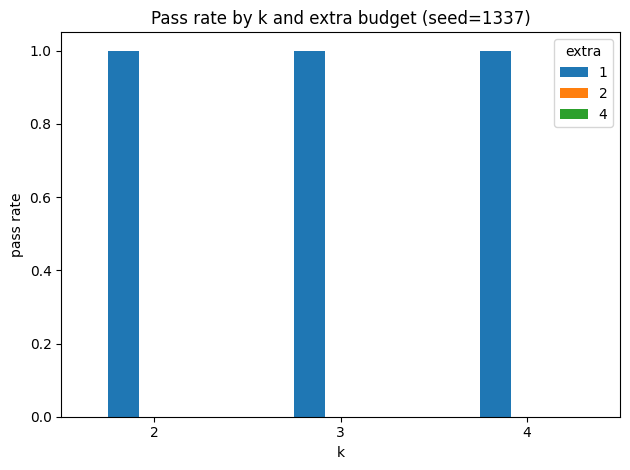

In [27]:
import matplotlib.pyplot as plt

# Aggregate pass rate by k and extra budget
pivot = df.pivot_table(values="pass", index="k", columns="extra", aggfunc="mean")
ax = pivot.plot(kind="bar", rot=0, title="Pass rate by k and extra budget (seed=1337)")
ax.set_ylabel("pass rate")
fig_path = FIG_DIR / "stress_firebreak_overview.png"
plt.tight_layout()
plt.savefig(fig_path, dpi=160)
print(f"saved {fig_path}")

